In [23]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBRFRegressor
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

class DataSetRegression():
    def __init__(self, X: pd.DataFrame, y: pd.Series):
        self.X = X.reset_index(drop=True)
        self.y = y
        self.X_transform = pd.DataFrame([])
        self.standart_scaler = StandardScaler()
        self.data = pd.concat([self.X, self.y], axis=1)
        self.ordEnc = OrdinalEncoder()
        
    def showMissData(self):
        miss_data = self.X.isnull().sum().sort_values()
        miss_data[miss_data > 0].plot.bar(color='green')
        return miss_data[miss_data > 0].index
        
    def fillNaMode(self, columns):
        for i in columns:
            self.X[i] = self.X[i].fillna(self.X[i].mode()[0])
            
    def ohe(self, columns, drop_first=True):
        self.X[columns] = self.X[columns].astype('str')
        self.X_transform = pd.concat([pd.get_dummies(self.X[columns], drop_first=drop_first), self.X_transform], axis=1)
        
    def notScale(self, columns):
        self.X_transform = pd.concat([self.X[columns], self.X_transform], axis=1)
    
    def standartSc(self, columns):
        sk = pd.DataFrame(self.standart_scaler.fit_transform(self.X[columns]), columns=columns)
        self.X_transform = pd.concat([sk, self.X_transform], axis=1)
    
    def train_test_split(self, *args, **kwargs):
        return train_test_split(self.X_transform[:len(self.y)], self.y, *args, **kwargs)
    
    def pred_data(self):
        return self.X_transform[len(self.y):]
    
    def all_train_data(self):
        return self.X_transform[:len(self.y)]
    
    def ordinalEnc(self, columns):
        self.X[columns] = self.X[columns].astype('str')
        gg = self.ordEnc.fit_transform(self.X[columns])
        oe = pd.DataFrame(gg, columns=columns)
        self.X_transform = pd.concat([self.X_transform, oe], axis=1)
    
    def corrMatrix(self, cols=None, n2show=25):
        corrM = self.data.corr()
        fig, ax = plt.subplots(dpi = 150, figsize=(10, 8))
        if cols is None:
            cols = corrM.nlargest(n2show, self.y.name)[self.y.name].index
        sns.heatmap(corrM.loc[cols, cols], annot=True, cmap="YlGnBu", linewidths=0.1,)
        return cols
    
    def quant(self, col='label', q=0.99):
        if col == 'label':
            quant = np.quantile(self.y, 0.99)
            self.y[self.y > quant] = quant
        else:
            quant = np.quantile(self.X[col], q)
            # print('{:15s} {:10.3e}'.format(col, quant))
            self.X.loc[self.X[col] > quant, col] = quant
            
    def showq_quant(self, col):
        d = pd.DataFrame.quantile(self.X[col], [0.0, 0.25, 0.5, 0.75, 1])
        d = d - d.iloc[2]
        d = d.append(d.iloc[0]/d.iloc[1], ignore_index=True)
        d = d.append(d.iloc[4]/d.iloc[3], ignore_index=True)
        d = d.set_index(pd.Index(['0%', '25%', '50%', '75%', '100%', '0/25', '1/75']))
        d = d.replace([np.inf, -np.inf], np.nan)
        return d.dropna(axis=1)

In [24]:
y = pd.read_csv('Htrain.csv').SalePrice
nn = pd.read_csv('000NNFeatures.csv').drop(columns=['Unnamed: 0'])
nn = nn.rename(columns={f'{i}': f'nn_{i}' for i in range(10)})
rff = pd.read_csv('000RFFeatures.csv').drop(columns=['Unnamed: 0'])
rff = rff.rename(columns={f'{i}': f'rff_{i}' for i in range(10)})
xgb = pd.read_csv('000XGBFeatures.csv').drop(columns=['Unnamed: 0'])
xgb = xgb.rename(columns={f'{i}': f'xgb_{i}' for i in range(10)})
nn['nn_mean'] = nn.mean(axis=1)
rff['rff_mean'] = rff.mean(axis=1)
xgb['xgb_mean'] = xgb.mean(axis=1)

dataset = DataSetRegression(pd.concat([nn, xgb, rff], axis=1), y)
dataset.notScale(['nn_mean', 'rff_mean', 'xgb_mean'])

['SalePrice', 'nn_mean', 'rff_mean', 'xgb_mean']

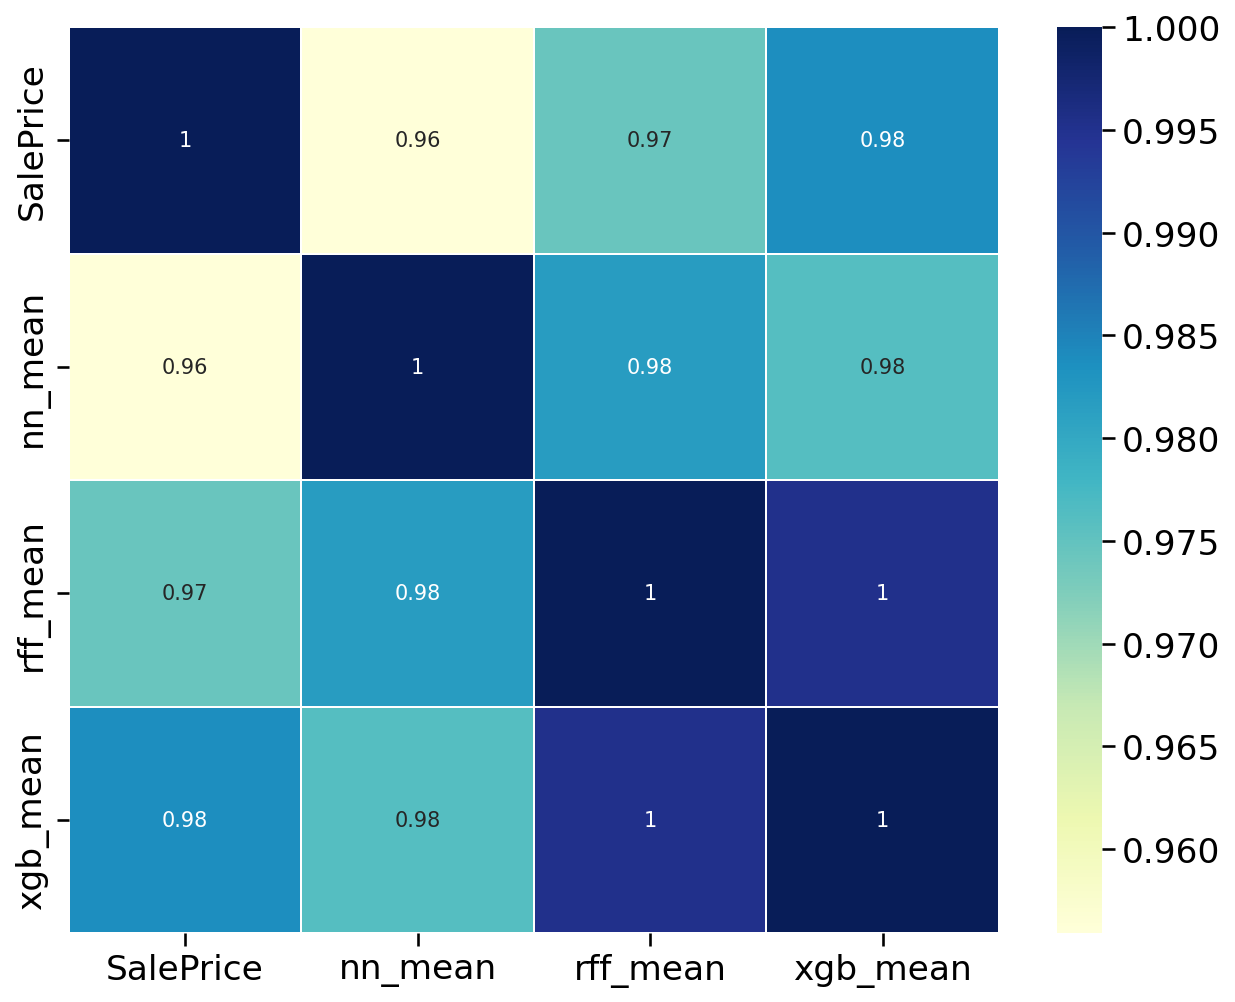

In [26]:
dataset.corrMatrix(['SalePrice', 'nn_mean', 'rff_mean', 'xgb_mean'])

In [29]:
from tqdm.auto import tqdm
n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)
predictions = []
with tqdm(total=n_splits, file=sys.stdout, leave=False) as prbar:
    for train, test in kf.split(dataset.all_train_data()):
        model = LassoCV()
        model.fit(dataset.all_train_data().iloc[train].values, dataset.y.iloc[train].values)
        preds = model.predict(dataset.all_train_data().iloc[test].values)
        print(mean_squared_error(preds, dataset.y.iloc[test].values, squared=False))
        prbar.update(1)
        print(model.coef_)
        predictions.append(model.predict(dataset.pred_data())[:, np.newaxis])

  0%|          | 0/10 [00:00<?, ?it/s]

24102.698378938276
[-0.00316134 -0.03174107  1.082979  ]
25242.700163496647
[-0.06760575 -0.01736961  1.13248244]
11101.411293649402
[-0.07306262 -0.          1.12492037]
9149.109202841511
[-0.03385163 -0.          1.08698052]
7811.460339294673
[-0.03490451 -0.          1.08933461]
10008.224756892785
[-0.08071524 -0.          1.13029334]
4550.498994808431
[-0.03427086 -0.          1.09087277]
5760.928312542448
[-0.03613791 -0.          1.09337649]
4616.923526286362
[-0.03772502 -0.          1.09584065]
19389.58097604077
[-0.04187398 -0.          1.08759857]


array([-0.04187398, -0.        ,  1.08759857])

In [30]:
answers = pd.read_csv('HAnswers.csv')
answers['SalePrice'] = np.hstack(predictions).mean(axis=1)

answers.to_csv('stackNNXGBRF.csv', index=False)